## 1. Module import

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 2. Data

In [46]:
df = pd.read_csv('../data/tfidf_output_cleaned.csv',encoding='latin1')
df.head()



,Label,Message,imp_feature
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


### Split data into 2 parts to train and test

In [47]:
x = df.iloc[: , -1]
y = df.iloc[: , 0]
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
X_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
# Convert a pandas Series to a DataFrame
X_train_series = pd.Series(X_train)
X_train_df = X_train_series.to_frame()


# Tạo RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Áp dụng oversampling cho dữ liệu huấn luyện
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_df, y_train)
X_train_resampled = X_train_resampled.squeeze()
#X_train_resampled,  y_train_resampled


## 3.Model

In [53]:

from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(X_train_resampled)

xgb = XGBClassifier().fit(x_train, y_train)

x_test = tfidf.transform(x_test)
y_pred_xgb = xgb.predict(x_test)

# from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold


# model = XGBClassifier()

# learning_rates = [0.1,0.2,0.3,0.4,0.5]
# max_depths = [5,6,7,8,9,10,15,20,25,30]
# # define grid search
# grid = dict(learning_rate=learning_rates,max_depth=max_depths)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(x_train, y_train_resampled)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


XGBoostError: [21:04:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\data.cc:501: Check failed: this->labels.Size() % this->num_row_ == 0 (4128 vs. 0) : Incorrect size for labels.

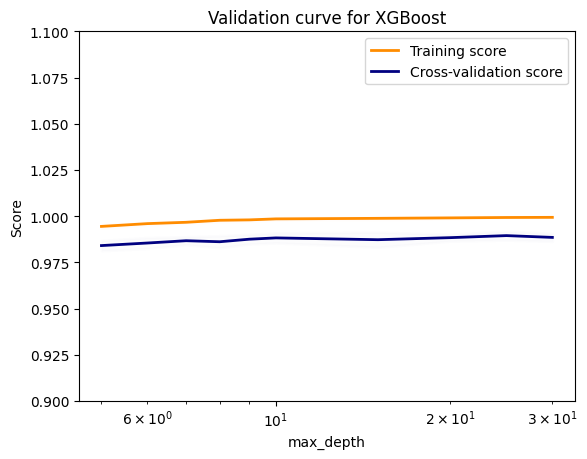

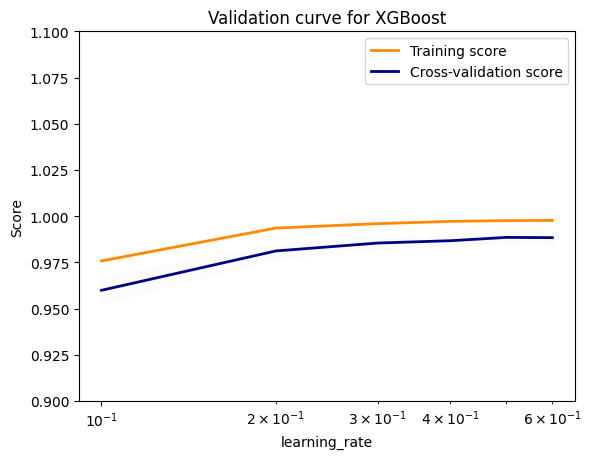

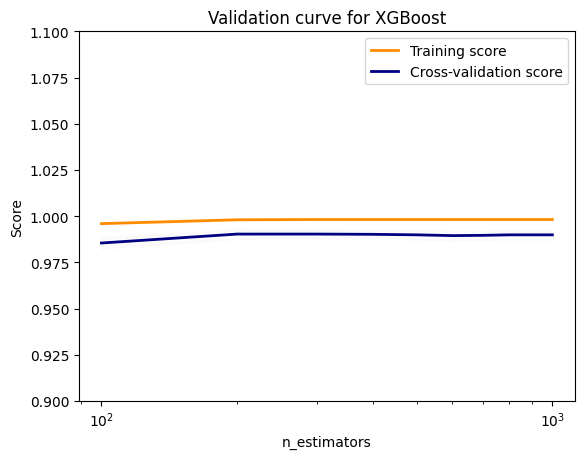

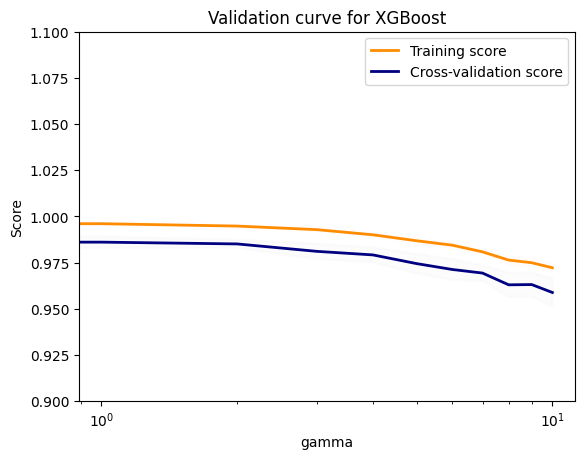

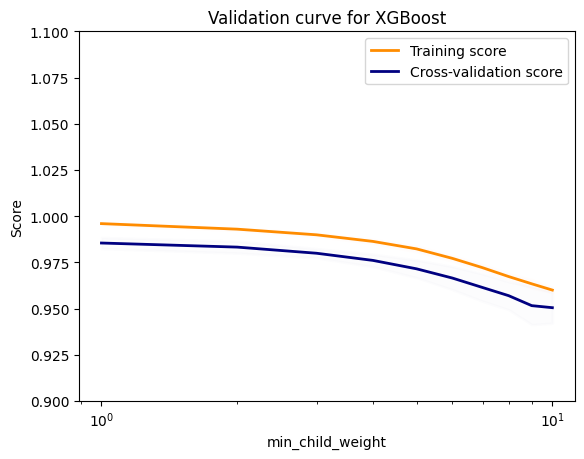

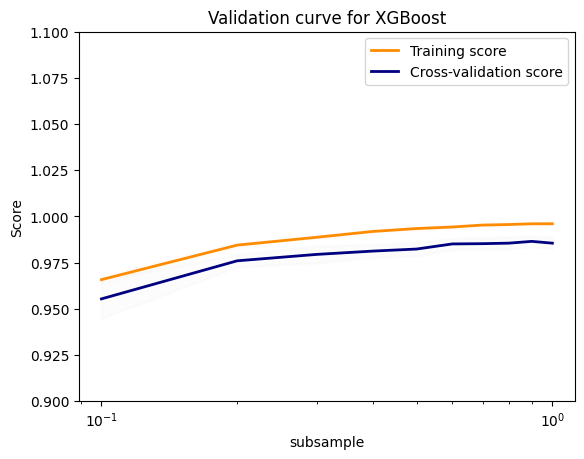

In [52]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

def plot_validation_curve(param_name,param_range):
    train_scores, test_scores = validation_curve(XGBClassifier(), x_train, y_train_resampled,
                                                param_name=param_name, param_range=param_range, cv=10, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title('Validation curve for XGBoost')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.ylim(0.9, 1.1)
    lw=2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        # train_scores_mean,
        # train_scores_mean,
        alpha=0.01,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        # test_scores_mean,
        # test_scores_mean,
        alpha=0.01,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()
    
plot_validation_curve('max_depth',[5,6,7,8,9,10,15,20,25,30])
plot_validation_curve('learning_rate',[0.1,0.2,0.3,0.4,0.5,0.6])
plot_validation_curve('n_estimators',[100,200,300,400,500,600,700,800,900,1000])
plot_validation_curve('gamma',[0,1,2,3,4,5,6,7,8,9,10])
plot_validation_curve('min_child_weight',[1,2,3,4,5,6,7,8,9,10])
plot_validation_curve('subsample',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# 4. Result

In [50]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,ConfusionMatrixDisplay,confusion_matrix
def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred))
    print("Recall : ", recall_score(y_test, y_pred))
    print("Accuracy Score : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred))
    print("\n", confusion_matrix(y_test, y_pred))
    print("")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=['Spam', 'Not Spam'] )
    cm_display.plot()
    plt.show()
    
perform(y_pred_xgb)

NameError: name 'y_pred_xgb' is not defined